In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

# Mean Fill

In [13]:
# clean data
train = pd.read_csv('./data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.mean())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables

# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24397.005804359607 logrmse: 0.11291591685262999


# Median Fill py27

In [4]:
# clean data
train = pd.read_csv('./data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.median())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables
#默认情况只对category and ojbect 进行 onehot 编码
# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24377.995089907552 logrmse: 0.1129396317760244


### Grid Search

In [ ]:
gs = GridSearch(xg_reg, {
    "n_estimators:":[100, 500, 1000, 3000],
    "alpha:":[0.01, 0.1, 1.0, 10],
    "lambda":[...]
})
# 可能重复搜索

### Randomized Search 

In [ ]:
gs = RandomizedSearch(xg_reg, {
    "n_estimators:":[100, 500, 1000, 3000],
    "alpha:":np.norm(1.0, 0.7),
    "lambda":[...]
})

In [6]:
print(train1.shape, X_train.shape, X_test.shape)

(1460, 79) (1168, 303) (292, 303)


## 交叉验证

1. 数据有限 ->发挥数据本来的效率

2. 数据的训练集和评测集的矛盾
      
      * 如果用更多的数据去训练，那么就会有更少的数据来评测->失去了对于真实泛化能力的考量
      * 如果用胜少的数据来训练，很大可能造成欠拟合，在评测集上表现就一定不好

解决办法：
1. 将数据集拆成k份->(首先进行shuffle)
2. 规定k-1份进行训练，剩下1份进行评测，总共训练k次，轮流每个子数据集作为评测集
    数据集被分成k份， 1....k
    第1次训练使用第1份数据作为评测集，剩余的k-1份作为训练集
    第i次训练使用第i份数据作为评测集，剩余的k-1份作为训练集
    做k次训练

3. k次训练之后，评测的分值=k次评测结果的平均
4. 不同的模型会提供不同的子模型合并方法，会将所有k个子模型进行合并

In [3]:
params = {"objective":"reg:linear",
          "cosample_bytree":0.7,
         'learning_rate':0.1,
         'max_depth':10,
         'alpha':10}

In [4]:
matrix = xgb.DMatrix(data=X, label=y)#xgboost 可以接受的Data的一种压缩后的数据结构. lmdb/.h5

In [7]:
cv_results = xgb.cv(params=params, 
       nfold=10, 
       num_boost_round=500, 
       metrics='rmse',
       as_pandas=True,
       dtrain = matrix)
#决策树的学习过程分为两个阶段，分裂和剪枝(前剪枝和后见剪枝)
cv_results.iloc[:,-2]

0      8711.733462
1      8202.652059
2      7697.323469
3      7274.846437
4      6899.888258
5      6673.243273
6      6615.601799
7      6566.754119
8      6636.492687
9      6694.054133
10     6615.733853
11     6767.991216
12     6939.023367
13     6912.493779
14     6887.301838
15     6912.054420
16     6927.188534
17     7023.409559
18     7210.247182
19     7379.079040
20     7423.768491
21     7487.440977
22     7608.119129
23     7705.599498
24     7760.267036
25     7767.541379
26     7753.369703
27     7764.175632
28     7746.057022
29     7723.968064
          ...     
470    7528.723523
471    7528.723002
472    7528.723103
473    7528.722735
474    7528.722976
475    7528.722808
476    7528.722312
477    7528.721967
478    7528.721700
479    7528.722260
480    7528.722231
481    7528.722008
482    7528.722067
483    7528.722404
484    7528.722799
485    7528.722429
486    7528.722464
487    7528.722239
488    7528.722711
489    7528.722420
490    7528.722044
491    7528.

## 数据的EDA入门

1. 数据属性分布分析(概率密度分析/是否呈现正态分布)
2. 数据属性与Target之间的相关性
3. 缺失属性相关性分析--进行合理的填充
4. 构造属性和构造属性的相关性分析

## 相关性分析
[-1, +1]

|r| > 0.95 显著关系

|r| >=0.8 强相关

|r| >=0.5 中度相关

0.5 >= |r| >= 0.3 弱相关（待挖掘，可以尝试去掉) 部分数据与该特征可能存在较强相关性。(楼房屋顶和顶楼的成交价格)

|r| < 0.3 极弱相关

In [24]:
corr = train.corr()['SalePrice']

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [30]:
corr = train.corr()['SalePrice']
corr[(corr>0.5) | (corr < -.5)].sort_values()

YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [31]:
corr[corr>0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

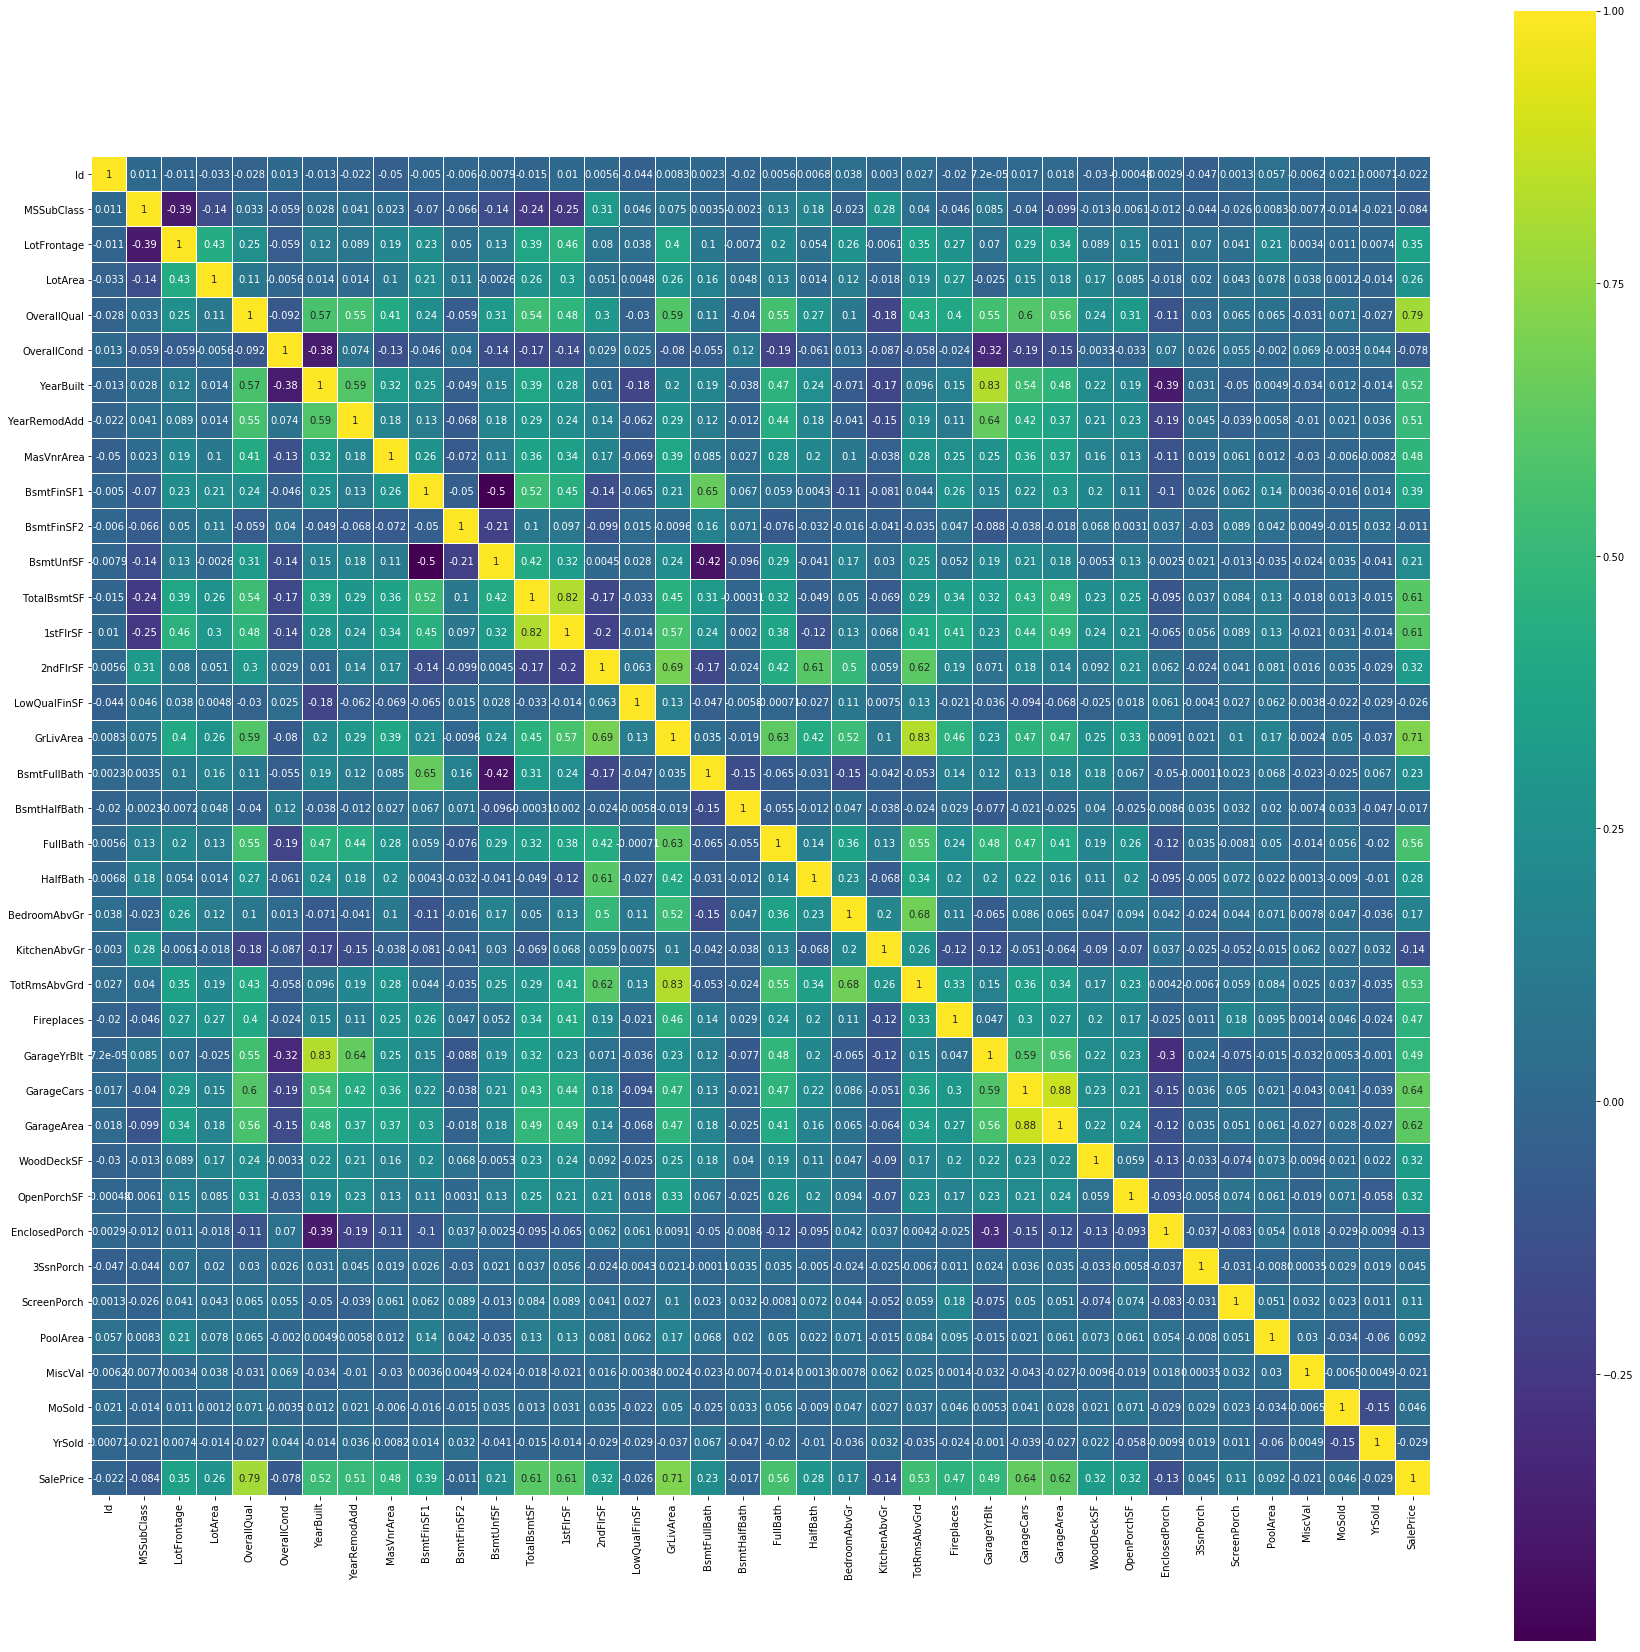

In [15]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(), linewidth=-.01, square=True, cmap='viridis', annot=True)

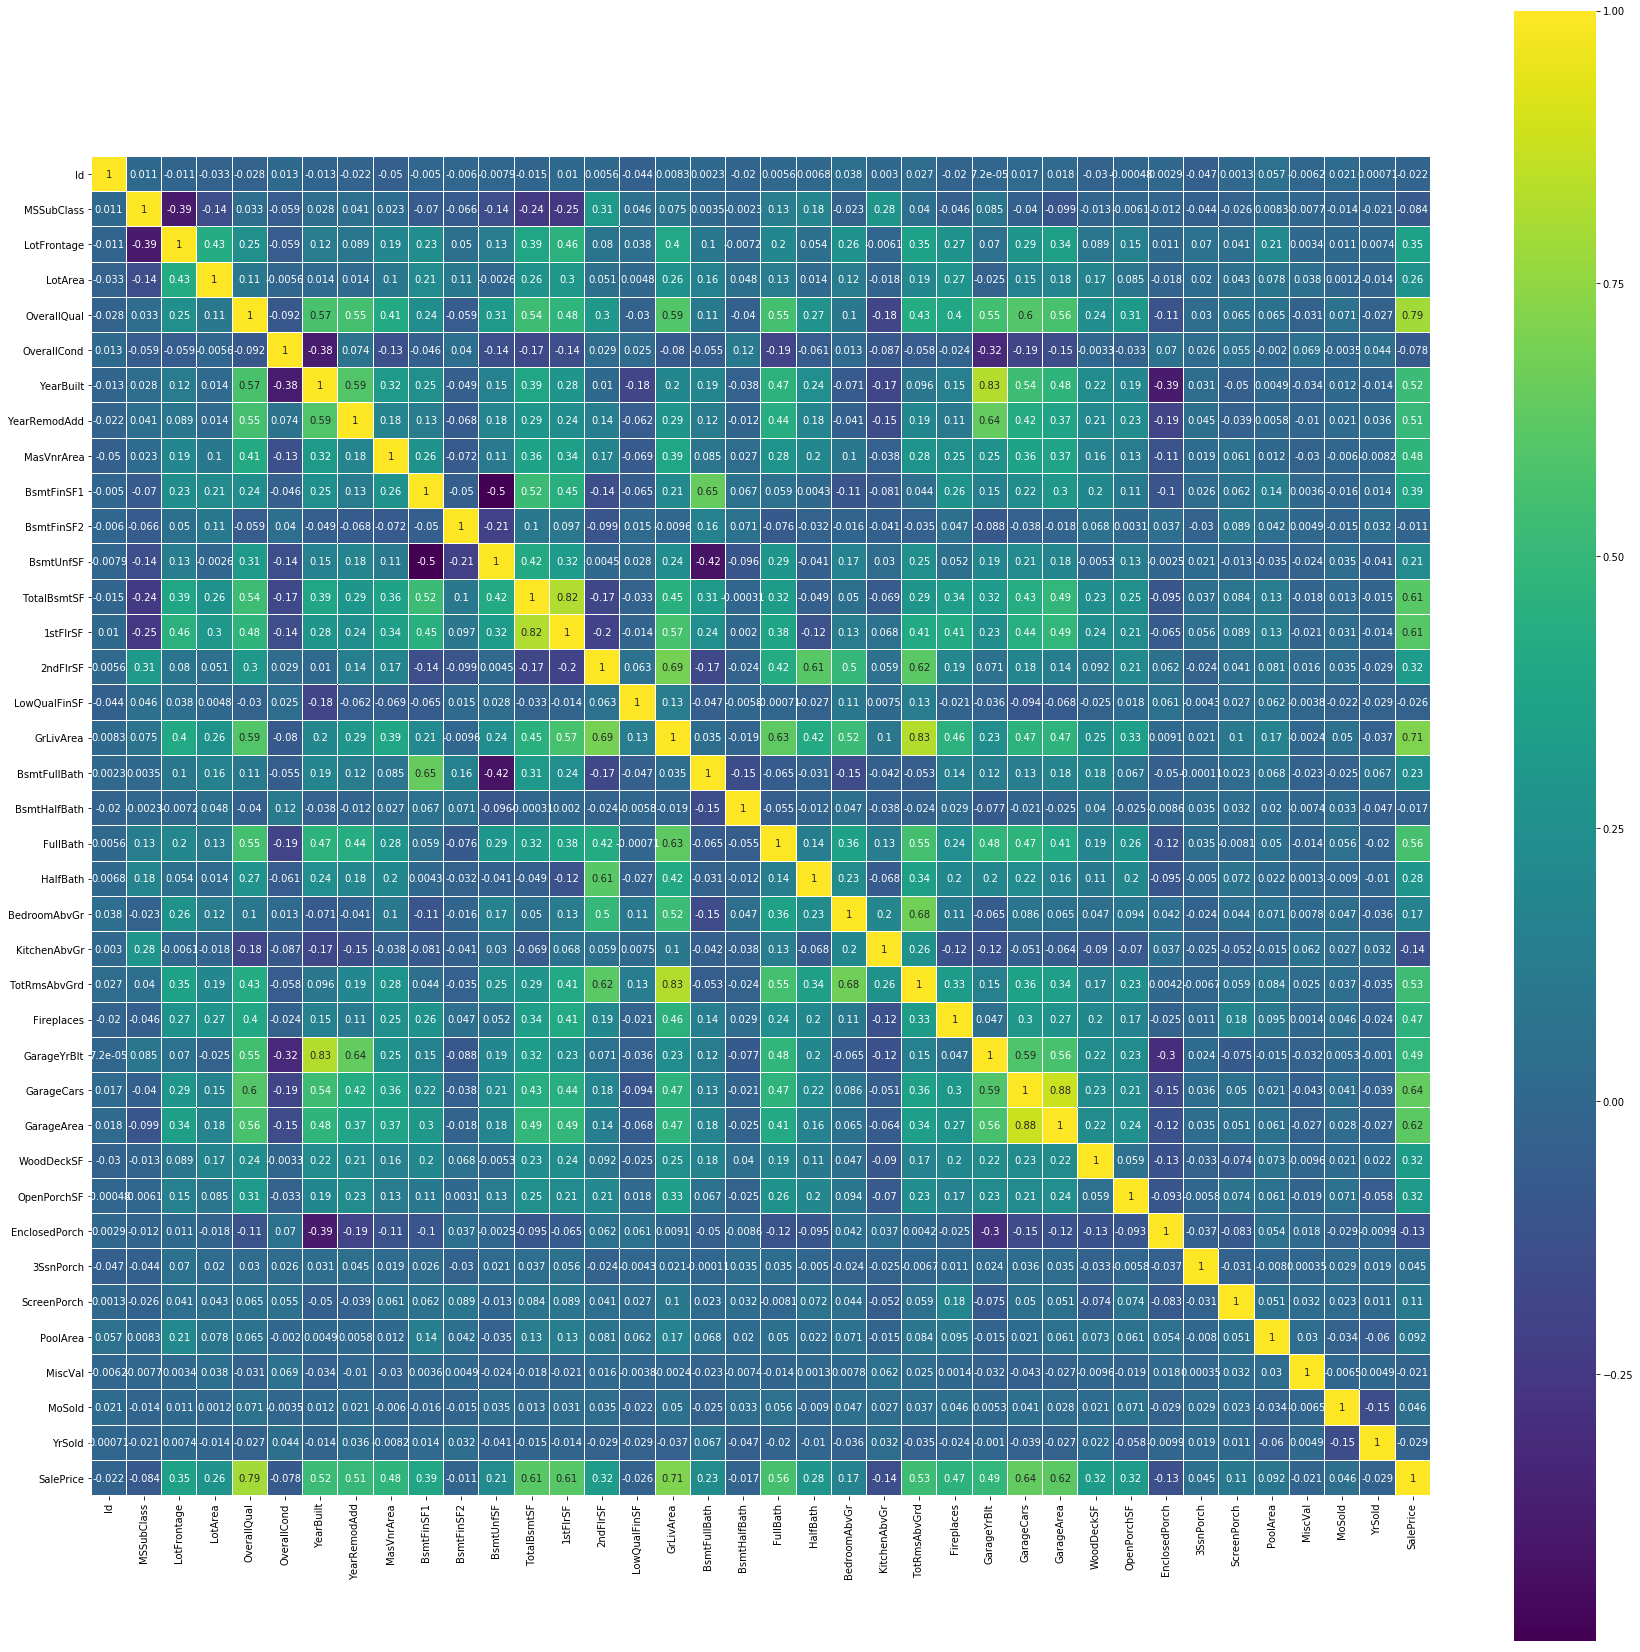

In [16]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(), linewidth=-.01, square=True, cmap='viridis', annot=True)

## 特征观察

观察特征与目标值之间的关系（使用统计图来进行观察)

In [17]:
corr = train.corr()['SalePrice']
corr[corr>0.5].sort_values()

YearRemodAdd    0.507101
YearBuilt       0.522897
TotRmsAbvGrd    0.533723
FullBath        0.560664
1stFlrSF        0.605852
TotalBsmtSF     0.613581
GarageArea      0.623431
GarageCars      0.640409
GrLivArea       0.708624
OverallQual     0.790982
SalePrice       1.000000
Name: SalePrice, dtype: float64

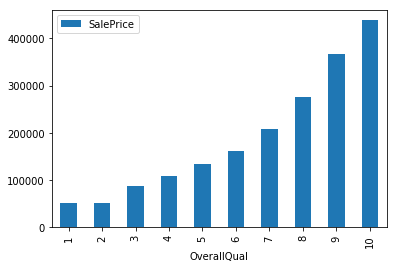

In [26]:
train[['OverallQual','SalePrice']].groupby(['OverallQual']).mean().plot.bar()

### 'GarageCars' 与 ‘SalePrice' 之间的关系

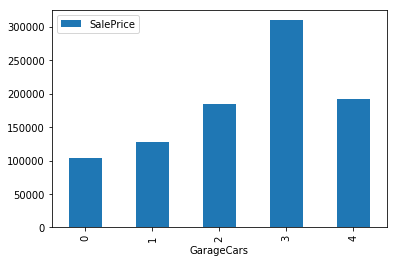

In [31]:
train[['GarageCars', 'SalePrice']].groupby(['GarageCars']).mean().plot.bar()

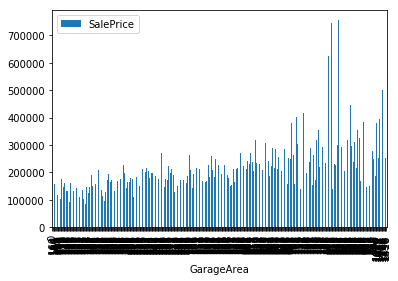

In [33]:
train[['GarageArea', 'SalePrice']].groupby(['GarageArea']).mean().plot.bar()
#不要将连续的数据进行groupby 这样没有意义， 如果想要对连续型数据进行grouby，需要对该数据进行分段。

